In [1]:
%load_ext autoreload
%autoreload 2

## Detect dates in the wiki dump

This processes 12 Million pages (2500 batches of 5000 pages) and takes 1h minutes on a good processor with 5 workers, probably 3 times that on an older one.


In [2]:
from wiki_dump_extractor import WikiAvroDumpExtractor
import utils.db_utils as db_utils
from utils.extraction_utils import find_dates_in_pages
from tqdm.auto import tqdm
from pathlib import Path

generated_data_dir = Path("generated_data")
dates_by_page_db = generated_data_dir / "dates_by_page_db"

wiki_data_dir = Path("wikipedia_data")
dump = WikiAvroDumpExtractor(wiki_data_dir / "wiki_dump.avro")

all_results = []
all_errors = []

if not dates_by_page_db.exists():
    batch_results = dump.process_page_batches_in_parallel(
        process_fn=find_dates_in_pages,
        batch_size=5000,
        num_workers=5,
    )
    with db_utils.LMDBWriter(dates_by_page_db, map_size=20_000_000_000) as db:
        for batch_result in tqdm(batch_results):
            all_results.extend(batch_result)
            db.write_batch(batch_result)

## Sort the dates found by year


In [4]:
import json
import zlib
from collections import defaultdict

year_min, year_max = -20_000, 2030
date_counts_by_year = defaultdict(lambda: 0)
pages_by_year = defaultdict(lambda: set())
date_bump_by_year = defaultdict(lambda: [])

with db_utils.LMDBReader(dates_by_page_db) as db:
    for page, zipped_dates in tqdm(db):
        dates = json.loads(zlib.decompress(zipped_dates).decode("utf-8"))
        for date in dates:
            year = date["date"]["year"]
            if year == 0:
                continue
            if 0 < year <= 100 and ("AD" not in date["date_str"]):
                date_bump_by_year[year].append(date)
                continue
            if not year_min < year < year_max:
                continue
            pages_by_year[year].add(page)
            date_counts_by_year[year] += 1


0it [00:00, ?it/s]

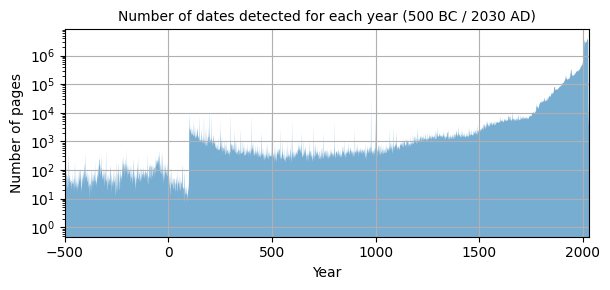

In [10]:
import matplotlib.pyplot as plt

years, values = zip(*sorted(e for e in date_counts_by_year.items()))

# Create the bar plot
fig, ax = plt.subplots(figsize=(6.21, 3))
ax.fill_between(years, values, alpha=0.6)
ax.set_xlim(-500, 2030)
ax.set_yscale("log")

ax.set_xlabel("Year")
ax.set_ylabel("Number of pages")
ax.set_title("Number of dates detected for each year (500 BC / 2030 AD)", fontsize=10)
ax.grid()
ax.figure.tight_layout()
ax.figure.savefig(generated_data_dir / "dates_by_year.png")

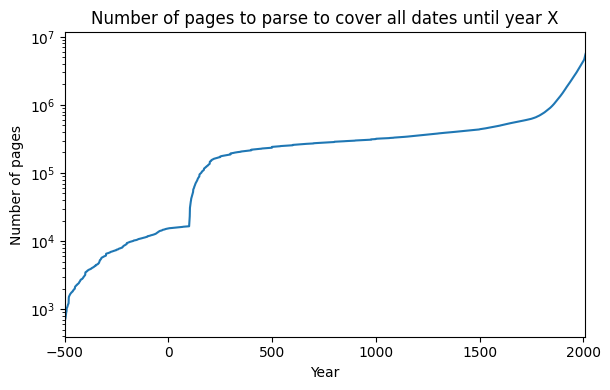

In [12]:
import matplotlib.pyplot as plt

years = list(range(-500, 2030))
n_pages_until_year = []
pages_until_year = set()
for year in years:
    pages = pages_by_year[year]
    pages_until_year.update(pages)
    n_pages_until_year.append(len(pages_until_year))

# Create the bar plot
fig, ax = plt.subplots(figsize=(6.21, 4))
ax.plot(years, n_pages_until_year)
ax.set_xlim(-500, 2010)
ax.set_yscale("log")

ax.set_xlabel("Year")
ax.set_ylabel("Number of pages")
ax.set_title("Number of pages to parse to cover all dates until year X")
plt.tight_layout()

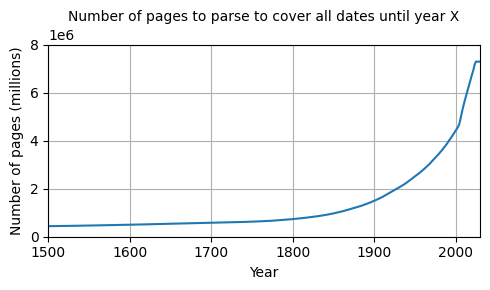

In [13]:
import matplotlib.pyplot as plt

# Create the bar plot
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(years, n_pages_until_year)
ax.set_xlim(1500, 2030)
ax.set_ylim(0, 8_000_000)
ax.set_xlabel("Year")
ax.set_ylabel("Number of pages (millions)")
ax.set_title("Number of pages to parse to cover all dates until year X", fontsize=10)
ax.grid()
ax.figure.tight_layout()
ax.figure.savefig(generated_data_dir / "pages_until_year.png")


In [12]:
# 100 million events in total
sum([date_counts_by_year[year] for year in date_counts_by_year.keys() if year >= 250])

100219084

## Select pages 250-1920 with many events


In [8]:
import utils.db_utils as db_utils
from tqdm.auto import tqdm
import json

target = generated_data_dir / "pages_250_1920_with_over_10_dates.json"
generated_data_dir = Path("generated_data")
dates_by_page_db = generated_data_dir / "dates_by_page_db"

if not target.exists():
    selected = []
    with db_utils.LMDBReader(dates_by_page_db) as db:
        for page, zipped_dates in tqdm(db):
            dates = json.loads(zlib.decompress(zipped_dates).decode("utf-8"))
            dates = [
                d
                for d in dates
                if d["date"]["year"] >= 250 and d["date"]["year"] <= 1920
            ]
            if len(dates) > 10:
                selected.append(page)
    print(len(selected))

    with target.open("w") as f:
        json.dump(selected, f)

0it [00:00, ?it/s]

256503
